In [178]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
from datetime import datetime
import numpy as np
import re
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import seaborn as sns

# Clean Data

## Data cleaning tasks include:
- Replace empty strings with NaN
- Remove the footnotes from the 'Other Source Deaths' column
- Convert Magnitude to a numeric
- Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.

## Additional cleaning tasks:
- Remove any clarifying parentheses from country entries
- Convert earthquake latitiude and longitude to geometric point
- Drop extraneous columns
- Convert time of earthquake to datetime type

In [327]:
#import wiki code as text file

response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result_text = response.text

In [328]:
#convert text to soup

soup = BS(result_text, 'html.parser')

In [329]:
# convert headers to list

column_headers = [th.getText() for th in 
                  soup.findAll('th')]

In [330]:
# create list of all data in table

data_rows = soup.findAll('tr')[6:] 

In [331]:
# parse out data in rows

earthquake_data = [[td.getText() for td in data_rows[i].findAll('td')]
            for i in range(len(data_rows))]

In [332]:
# create dataframe

df = pd.DataFrame(earthquake_data, columns=column_headers)

In [333]:
df.columns = ['origin','country','lat','lng','depth','magnitude','secondary_effects','pde_shaking_deaths','pde_total_deaths','utsu_total_deaths','emdat_total_deaths','other_deaths']

In [339]:
df['month'] = df.origin.str[5:7]

In [340]:
df['origin'] = pd.to_datetime(df.origin)

In [341]:
df.other_deaths = df.other_deaths.str[:-1]

In [342]:
#replace all blank cells with NaN

df = df.replace('', np.NaN)

In [343]:
#replace all NaN in secondary effects to None
df['secondary_effects'] = df['secondary_effects'].replace(np.NaN,'None')

In [344]:
#resolve any weird data errors that have a comma, footnote, or aren't formatted correctly to convert to number

df.at[43, 'other_deaths'] = 8000
df.at[66,'other_deaths'] = 164
df.at[99,'other_deaths'] = 1500
df.at[1078,'other_deaths'] = 45000
df.at[1082,'other_deaths'] = 2489
df.at[1206,'other_deaths'] = 26000
df.at[1238,'other_deaths'] = 283000
df.at[1339,'other_deaths'] = 601
df.at[1338,'other_deaths'] = 111
df.at[1336,'other_deaths'] = 150
df.at[1335,'other_deaths'] = 15894
df.at[1329,'other_deaths'] = 521
df.at[1328,'other_deaths'] = 221517
df.at[1318,'other_deaths'] = 60
df.at[439,'emdat_total_deaths'] = '10'
df.at[413,'emdat_total_deaths'] = ''
df.at[958,'other_deaths'] = '33'
df.at[1327,'other_deaths'] = '1115'
df.at[1332,'other_deaths'] = '2698'

In [345]:
#convert all deaths to numeric

df.pde_shaking_deaths = pd.to_numeric(df.pde_shaking_deaths)
df.pde_total_deaths = pd.to_numeric(df.pde_total_deaths)
df.utsu_total_deaths = pd.to_numeric(df.utsu_total_deaths)
df.emdat_total_deaths = pd.to_numeric(df.emdat_total_deaths)
df.other_deaths = pd.to_numeric(df.other_deaths)

In [346]:
#create a column called total deaths that has the max of the deaths columns

df['total_deaths'] = df.iloc[:,-5:].max(axis = 1)

In [347]:
#change anywhere with NaN deaths to 0 deaths

df['total_deaths'] = df.total_deaths.fillna(0)

In [348]:
#Use regex to remove all the parentheses info in the Country column

df.country = df.country.str.replace(r"\(.*\)","")
df.country = df.country.str.replace(r"\(.*","")

In [349]:
# Extract number on magnitude scale

df.magnitude = df.magnitude.str[0:3]

In [350]:
# Drop weird cell

df = df.drop(df.index[413])

In [351]:
# Clean weird cell

df.at[439, 'magnitude'] = "5.0"

In [352]:
# Convert magnitude to numeric

df.magnitude = pd.to_numeric(df.magnitude)

In [353]:
df['geometry'] = df.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [354]:
df = df.drop(['pde_shaking_deaths','pde_total_deaths','utsu_total_deaths','emdat_total_deaths','other_deaths'], axis = 1)

## Cleaned Data:

In [355]:
df.head()

origin    country     lat      lng depth  magnitude  \
0 1900-05-11 17:23:00      Japan  38.700  141.100     5        7.0   
1 1900-07-12 06:25:00     Turkey  40.300   43.100   NaN        5.9   
2 1900-10-29 09:11:00  Venezuela  11.000  -66.000     0        7.7   
3 1901-02-15 00:00:00      China  26.000  100.100     0        6.5   
4 1901-03-31 07:11:00   Bulgaria  43.400   28.700   NaN        6.4   

  secondary_effects month  total_deaths            geometry  
0              None    05           5.0  POINT (141.1 38.7)  
1              None    07           7.0   POINT (43.1 40.3)  
2              None    10          10.0      POINT (-66 11)  
3              None    02           2.0    POINT (100.1 26)  
4              None    03           3.0   POINT (28.7 43.4)

# Analysis

## Earthquakes
- Nate Silver discusses the difficulty of predicting earthquakes in The Signal and the Noise, but are there factors that make an earthquake more likely?
- Are there factors that make an earthquake more deadly?
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
- Where would you avoid living?

## Are there factors that make an earthquake more deadly?
### Do secondary effects, such as tsunamis or landslides, make an earthquake more deadly?

### Four Primary Secondary Effects 
<ol> 
    <li> Tsunami (T) </li>
    <li> Landslide (L) </li>
    <li> Fire (F) </li>
    <li> Liquefaction (Lq) </li>
</ol>


<a href='https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'> Source </a>

### How common are secondary effects?

In [356]:
df.secondary_effects.value_counts()

None      966
L         165
T         144
T,L        26
L,Lq       10
F           9
T,F         5
T,L,Lq      4
Lq          4
T,LF        2
T,Lq        2
L,F,Lq      1
L,F         1
Name: secondary_effects, dtype: int64

In [357]:
df.secondary_effects.value_counts().sum()

1339

## For all significant earthquakes measured between 1900 and 2011, 967 of the 1,340 had no secondary effects.

## 72% of earthquakes have no secondary effect.

## The most common secondary effects are:
<ol>
    <li>Landslide</li>
    <li>Tsunami</li>
    <li>Tsunami and Landslide</li>
    <li>Landslide and Liquefaction</li>
    <li>Fire</li>
 </ol>

In [358]:
deaths_by_effect = pd.DataFrame(df.groupby('secondary_effects')['total_deaths'].mean())

In [359]:
deaths_by_effect = deaths_by_effect.reset_index()

In [360]:
deaths_by_effect = pd.DataFrame(deaths_by_effect.loc[
    (deaths_by_effect['secondary_effects'] == 'T') |
    (deaths_by_effect['secondary_effects'] == 'F')|
    (deaths_by_effect['secondary_effects'] == 'T,L') |
    (deaths_by_effect['secondary_effects'] == 'L,Lq') |
    (deaths_by_effect['secondary_effects'] == 'None') |
    (deaths_by_effect['secondary_effects'] == 'L')])

In [361]:
deaths_by_effect = deaths_by_effect.sort_values('total_deaths').reset_index()

In [362]:
deaths_by_effect['label'] = ['Fire', 'Tsunami', 'Landslide', 'No Secondary Effect','Landslide and liquefaction','Tsunami and landslide']

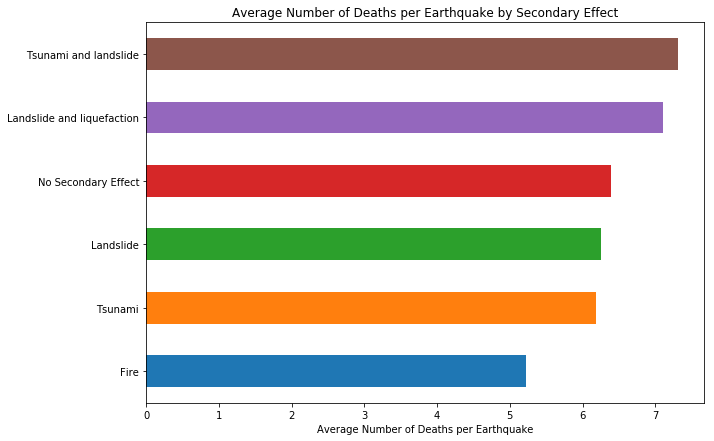

In [363]:
deaths_by_effect.plot.barh(x='label', y='total_deaths', rot=0, title ='Average Number of Deaths per Earthquake by Secondary Effect', legend = False, 
                          figsize = (10,7))
plt.xlabel("Average Number of Deaths per Earthquake")
plt.ylabel('');

# Are there factors that make an earthquake more likely?

## Do earthquakes occur in batches of 10 or more within 60 days of each other?

In [364]:
df_times = df.sort_values('origin')

#problem_users = accre_5min.groupby('User').rolling('4h', on = 'Submit').JobIDRaw.count()

In [365]:
df_times.head()

origin    country     lat      lng depth  magnitude  \
0 1900-05-11 17:23:00      Japan  38.700  141.100     5        7.0   
1 1900-07-12 06:25:00     Turkey  40.300   43.100   NaN        5.9   
2 1900-10-29 09:11:00  Venezuela  11.000  -66.000     0        7.7   
3 1901-02-15 00:00:00      China  26.000  100.100     0        6.5   
4 1901-03-31 07:11:00   Bulgaria  43.400   28.700   NaN        6.4   

  secondary_effects month  total_deaths            geometry  
0              None    05           5.0  POINT (141.1 38.7)  
1              None    07           7.0   POINT (43.1 40.3)  
2              None    10          10.0      POINT (-66 11)  
3              None    02           2.0    POINT (100.1 26)  
4              None    03           3.0   POINT (28.7 43.4)

In [366]:
df_times['count'] = df_times.rolling('60d', on = 'origin').total_deaths.count()

In [367]:
df_times.loc[df_times['count'] == 10]

origin       country     lat      lng depth  magnitude  \
588  1976-08-19 01:12:00        Turkey  37.743   29.015  11.7        5.0   
590  1976-09-11 16:31:00         Italy  46.339   13.181   4.2        5.5   
591  1976-09-15 03:15:00        Italy   46.314   13.206   0.9        6.0   
651  1979-12-17 19:58:00     Indonesia  -8.487  115.753    15        6.5   
872  1990-06-14 12:47:00    Kazakhstan  47.877   85.064    36        6.6   
877  1990-07-16 07:26:00  Philippines   15.721  121.180  24.3        7.7   
1096 1999-12-22 17:36:00       Algeria  35.210   -1.316   2.3        5.6   
1110 2000-07-01 07:01:00         Japan  34.222  139.171  12.5        6.1   
1111 2000-07-06 19:30:00     Nicaragua  11.928  -86.066    15        5.4   
1112 2000-07-07 00:15:00        Turkey  40.857   29.344   7.8        4.2   
1158 2002-04-24 19:48:00          Iran  34.602   47.401    25        5.4   
1160 2002-05-15 03:46:00        Taiwan  24.668  121.868  16.7        6.1   
1217 2004-03-07 06:37:00       Morocco  35.174   -4.161  34.6        5.1   

     secondary_effects month  total_deaths                          geometry  \
588               None    08           8.0             POINT (29.015 37.743)   
590                  L    09           9.0             POINT (13.181 46.339)   
591               None    09           9.0             POINT (13.206 46.314)   
651               None    12          12.0            POINT (115.753 -8.487)   
872               None    06           6.0  POINT (85.06399999999999 47.877)   
877               L,Lq    07           7.0             POINT (121.18 15.721)   
1096              None    12          12.0              POINT (-1.316 35.21)   
1110               T,L    07           7.0            POINT (139.171 34.222)   
1111              None    07           7.0            POINT (-86.066 11.928)   
1112              None    07           7.0             POINT (29.344 40.857)   
1158              None    04           4.0             POINT (47.401 34.602)   
1160                 L    05           5.0            POINT (121.868 24.668)   
1217              None    03           3.0             POINT (-4.161 35.174)   

      count  
588    10.0  
590    10.0  
591    10.0  
651    10.0  
872    10.0  
877    10.0  
1096   10.0  
1110   10.0  
1111   10.0  
1112   10.0  
1158   10.0  
1160   10.0  
1217   10.0

In [368]:
df_times.iloc[560:600,:]

origin       country      lat      lng  depth  magnitude  \
561 1975-12-30 14:36:00        Turkey   38.595   40.526   31.8        4.6   
562 1975-12-31 09:45:00        Greece   38.526   21.714     15        5.5   
563 1976-01-13 13:29:00       Iceland   66.226  -16.578     15        6.3   
564 1976-02-04 09:01:00    Guatemala    15.296  -89.145   12.3        7.5   
565 1976-02-04 09:30:00    Guatemala    14.812  -90.469   60.4        5.4   
566 1976-02-19 13:59:00          Cuba   19.864  -76.899   21.1        5.9   
567 1976-03-13 16:30:00     Guatemala   14.725  -91.006     15        5.4   
568 1976-03-19 13:03:00   Afghanistan   36.587   67.758   18.2        5.6   
569 1976-03-25 11:55:00        Turkey   40.939   42.954     35        4.8   
570 1976-04-02 16:58:00        Turkey   39.801   43.689     25        4.6   
571 1976-04-05 16:54:00         China   40.230  112.222      7        5.5   
572 1976-04-09 07:08:00       Ecuador    0.850  -79.564     17        6.6   
573 1976-04-29 22:18:00        Turkey   40.935   42.875     35        5.5   
574 1976-05-06 20:00:00        Italy    46.385   13.266   20.7        6.5   
575 1976-05-15 21:55:00          Peru  -11.660  -74.419     19        6.7   
576 1976-05-17 02:58:00    Uzbekistan   40.373   63.428   14.8        6.7   
577 1976-05-29 12:23:00         China   24.501   98.930    6.5        6.7   
578 1976-05-29 14:00:00         China   24.581   98.610    7.6        6.6   
579 1976-06-25 19:18:00    Indonesia    -4.531  140.109     15        7.1   
580 1976-07-09 09:34:00        Turkey   38.327   40.463     33        4.2   
581 1976-07-14 07:13:00     Indonesia   -8.228  114.774   24.8        6.5   
582 1976-07-21 15:10:00         China   24.768   98.667    4.3        6.1   
583 1976-07-27 19:42:00        China    39.605  117.888   16.7        7.6   
584 1976-07-28 10:45:00         China   39.723  118.359   18.2        7.0   
585 1976-08-16 14:06:00        China    32.753  104.088   10.7        6.7   
586 1976-08-16 16:11:00  Philippines     6.292  124.089   57.9        8.0   
587 1976-08-17 04:19:00   Philippines    7.259  122.960   20.2        7.1   
588 1976-08-19 01:12:00        Turkey   37.743   29.015   11.7        5.0   
589 1976-08-23 03:30:00         China   32.481  104.182    7.9        6.4   
590 1976-09-11 16:31:00         Italy   46.339   13.181    4.2        5.5   
591 1976-09-15 03:15:00        Italy    46.314   13.206    0.9        6.0   
592 1976-09-15 09:21:00         Italy   46.354   13.087    9.7        5.9   
593 1976-10-06 09:12:00       Ecuador   -0.726  -78.732    4.7        5.7   
594 1976-10-29 02:51:00     Indonesia   -4.475  139.991     15        6.8   
595 1976-11-06 18:04:00         China   27.554  101.021    7.7        6.3   
596 1976-11-07 04:00:00          Iran   33.820   59.180    6.5        6.0   
597 1976-11-24 12:22:00       Turkey    39.082   44.031    8.9        7.0   
598 1976-11-30 00:40:00         Chile  -20.472  -68.896  133.7        7.5   
599 1976-12-08 08:38:00  South Africa  -27.979   26.677     10        5.2   
600 1976-12-13 06:36:00         China   27.336  101.024    3.4        5.9   

    secondary_effects month  total_deaths                           geometry  \
561              None    12          12.0              POINT (40.526 38.595)   
562              None    12          12.0              POINT (21.714 38.526)   
563              None    01           1.0             POINT (-16.578 66.226)   
564                 T    02           2.0             POINT (-89.145 15.296)   
565              None    02           2.0  POINT (-90.46899999999999 14.812)   
566              None    02           2.0             POINT (-76.899 19.864)   
567                 L    03           3.0             POINT (-91.006 14.725)   
568                 L    03           3.0              POINT (67.758 36.587)   
569              None    03           3.0              POINT (42.954 40.939)   
570              None    04           4.0              POIN

In [369]:
df_times.iloc[1100:1113,:]

origin      country      lat      lng depth  magnitude  \
1101 2000-05-04 04:21:00    Indonesia   -1.140  123.522    26        7.5   
1102 2000-05-07 23:10:00       Turkey   38.164   38.777     5        4.5   
1103 2000-05-12 18:43:00    Argentina  -23.754  -66.777   225        7.2   
1104 2000-05-17 03:25:00       Taiwan   24.167  121.078    15        5.4   
1105 2000-06-04 16:28:00    Indonesia   -4.760  102.031  33.8        7.9   
1106 2000-06-05 23:55:00    Indonesia   -4.151  101.953    47        5.5   
1107 2000-06-06 02:41:00       Turkey   40.737   33.005     7        6.0   
1108 2000-06-07 23:45:00    Indonesia   -4.651  101.848    32        6.7   
1109 2000-06-10 18:23:00       Taiwan   23.868  121.181    19        6.4   
1110 2000-07-01 07:01:00        Japan   34.222  139.171  12.5        6.1   
1111 2000-07-06 19:30:00    Nicaragua   11.928  -86.066    15        5.4   
1112 2000-07-07 00:15:00       Turkey   40.857   29.344   7.8        4.2   
1113 2000-07-17 22:53:00  Afghanistan   36.245   70.943   135        6.3   

     secondary_effects month  total_deaths                 geometry  count  
1101                 T    05           5.0    POINT (123.522 -1.14)    1.0  
1102              None    05           5.0    POINT (38.777 38.164)    2.0  
1103              None    05           5.0  POINT (-66.777 -23.754)    3.0  
1104                 L    05           5.0   POINT (121.078 24.167)    4.0  
1105                 L    06           6.0    POINT (102.031 -4.76)    5.0  
1106              None    06           6.0   POINT (101.953 -4.151)    6.0  
1107              None    06           6.0    POINT (33.005 40.737)    7.0  
1108              None    06           6.0   POINT (101.848 -4.651)    8.0  
1109                 L    06           6.0   POINT (121.181 23.868)    9.0  
1110               T,L    07           7.0   POINT (139.171 34.222)   10.0  
1111              None    07           7.0   POINT (-86.066 11.928)   10.0  
1112              None    07           7.0    POINT (29.344 40.857)   10.0  
1113              None    07           7.0    POINT (70.943 36.245)    9.0

## There are peaks of earthquake activity in:
- Fall 1976
- Winter 1979
- Summer 1990
- Summer 1999
- Winter 1999
- Summer 2000
- Spring 2002
- Spring 2004

In [374]:
months = pd.DataFrame(df_times.groupby('month')['magnitude'].count())

In [376]:
months = months.reset_index()

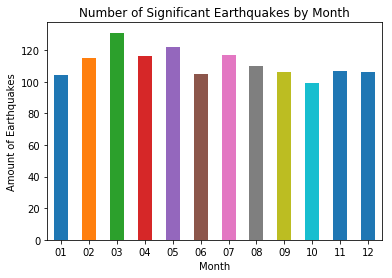

In [383]:
months.plot.bar(x='month', y='magnitude', rot=0, title ='Number of Significant Earthquakes by Month', legend = False)
plt.xlabel("Month")
plt.ylabel('Amount of Earthquakes');

In [387]:
months_mag = pd.DataFrame(df_times.groupby('month')['magnitude'].mean()).reset_index()

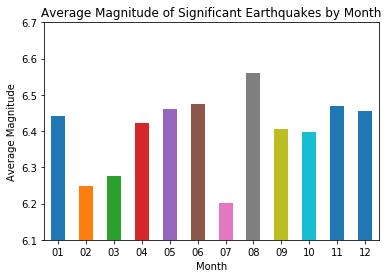

In [396]:
months_mag.plot.bar(x='month', y='magnitude', rot=0, title ='Average Magnitude of Significant Earthquakes by Month', legend = False)
plt.xlabel("Month")
plt.ylim(6.1,6.7)
plt.ylabel('Average Magnitude');

# Focus
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
- Where would you avoid living?

## About Earthquake Magnitude

<img src = "https://i.cbc.ca/1.1877835.1380772347!/httpImage/image.jpg_gen/derivatives/original_780/earthquake-magnitude.jpg" width="300" height="600" align = 'left'>

In [31]:
usa = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/all_month.csv', usecols=[0,1,2,3,4])

In [32]:
usa.head()

time   latitude   longitude   depth   mag
0  2018-09-25T23:55:30.290Z  33.508000 -116.800667    2.71  1.42
1  2018-09-25T23:47:51.764Z  60.195300 -153.153200  132.20  1.80
2  2018-09-25T23:38:40.870Z  33.515833 -116.788333    6.66  0.47
3  2018-09-25T23:37:40.574Z  60.934000 -152.458700  105.60  1.40
4  2018-09-25T23:34:28.040Z  33.335000 -116.166667   10.31  0.86

In [33]:
usa.columns = ['time','lat','lng','depth','magnitude']

In [34]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 5 columns):
time         9937 non-null object
lat          9937 non-null float64
lng          9937 non-null float64
depth        9937 non-null float64
magnitude    9935 non-null float64
dtypes: float64(4), object(1)
memory usage: 388.2+ KB


In [35]:
usa['geometry'] = usa.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [36]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9937 entries, 0 to 9936
Data columns (total 6 columns):
time         9937 non-null object
lat          9937 non-null float64
lng          9937 non-null float64
depth        9937 non-null float64
magnitude    9935 non-null float64
geometry     9937 non-null object
dtypes: float64(4), object(2)
memory usage: 465.9+ KB


In [37]:
states = gpd.read_file('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/gz_2010_us_040_00_5m.json')

In [38]:
usa_geo = gpd.GeoDataFrame(usa, crs = states.crs, geometry = usa['geometry'])

In [39]:
usa_by_state = gpd.sjoin(usa_geo, states)

In [40]:
usa_by_state.head()

time        lat         lng  depth  magnitude  \
0   2018-09-25T23:55:30.290Z  33.508000 -116.800667   2.71       1.42   
2   2018-09-25T23:38:40.870Z  33.515833 -116.788333   6.66       0.47   
4   2018-09-25T23:34:28.040Z  33.335000 -116.166667  10.31       0.86   
5   2018-09-25T23:34:09.460Z  38.828335 -122.784164   1.38       0.72   
11  2018-09-25T23:05:50.640Z  33.104500 -116.427167  11.71       1.11   

                           geometry  index_right       GEO_ID STATE  \
0       POINT (-116.8006667 33.508)            4  0400000US06    06   
2   POINT (-116.7883333 33.5158333)            4  0400000US06    06   
4       POINT (-116.1666667 33.335)            4  0400000US06    06   
5   POINT (-122.7841644 38.8283348)            4  0400000US06    06   
11     POINT (-116.4271667 33.1045)            4  0400000US06    06   

          NAME LSAD  CENSUSAREA  
0   California        155779.22  
2   California        155779.22  
4   California        155779.22  
5   California        155779.22  
11  California        155779.22

In [41]:
usa_lower48 = usa_by_state.loc[usa_by_state['NAME'] != "Alaska"]
usa_lower48 = usa_lower48.loc[usa_lower48['NAME'] != 'Hawaii']

# This map plots all earthquakes in the Lower 48 states of the USA in September 2018.

In [42]:
map_earthquakes = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in usa_lower48.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['lat'],  row_values['lng']]))
    
map_earthquakes.add_child(mc) 

map_earthquakes

In [43]:
world2018 = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/query (1).csv')

In [44]:
world2018.head()

time  latitude  longitude   depth  mag magType  nst  \
0  2018-09-28T00:26:30.550Z   37.0440    30.4969  106.17  4.0      mb  NaN   
1  2018-09-27T23:36:51.500Z   -7.4532   128.5127  154.42  4.5      mb  NaN   
2  2018-09-27T22:25:43.970Z  -18.1652  -178.2429  540.20  5.5     mww  NaN   
3  2018-09-27T22:00:21.110Z  -11.3478   -76.7084   44.89  4.8      mb  NaN   
4  2018-09-27T21:45:16.567Z   56.4112  -148.4244   10.00  3.0      ml  NaN   

     gap   dmin   rms    ...                      updated  \
0   96.0  0.556  0.83    ...     2018-09-28T00:47:25.445Z   
1   65.0  2.810  1.03    ...     2018-09-28T00:29:46.040Z   
2   34.0  3.550  1.10    ...     2018-09-28T00:27:52.125Z   
3  100.0  0.649  0.76    ...     2018-09-27T23:07:24.556Z   
4    NaN    NaN  0.63    ...     2018-09-27T22:38:53.471Z   

                             place        type horizontalError depthError  \
0       23km NW of Antalya, Turkey  earthquake             5.4        6.3   
1  Kepulauan Barat Daya, Indonesia  earthquake             7.1        8.0   
2     279km N of Ndoi Island, Fiji  earthquake             8.8        6.4   
3    55km N of Santa Eulalia, Peru  earthquake             7.2        8.6   
4      286km ESE of Kodiak, Alaska  earthquake             NaN        0.0   

   magError  magNst    status  locationSource magSource  
0     0.108    23.0  reviewed              us        us  
1     0.093    34.0  reviewed              us        us  
2     0.073    18.0  reviewed              us        us  
3     0.049   127.0  reviewed              us        us  
4       NaN     NaN  reviewed              ak        ak  

[5 rows x 22 columns]

# This map shows all earthquakes in the world with a magnitude of 2.5 or higher in September 2018.

In [45]:
world_earthquakes = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in world2018.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['latitude'],  row_values['longitude']]))
    
world_earthquakes.add_child(mc) 

world_earthquakes

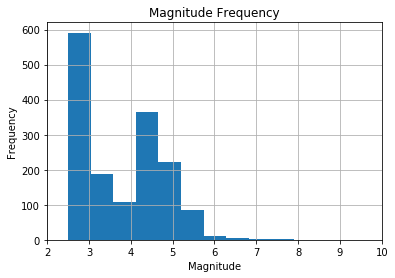

In [46]:
world2018.hist('mag')
plt.title('Magnitude Frequency')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.xlim(2,10);

In [47]:
countries = gpd.read_file('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/world-countries.json')

In [48]:
world2018['geometry'] = world2018.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)

In [49]:
world_geo_2018 = gpd.GeoDataFrame(world2018, crs = countries.crs, geometry = world2018['geometry'])

In [50]:
world_all_2018 = gpd.sjoin(world_geo_2018, countries)

In [51]:
world2008 = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/2008quakes.csv')

In [52]:
world1998 = pd.read_csv('/Users/rabram/Desktop/NSS/data-question-3-earthquakes-high-voltage-1/data/1998quakes.csv')

# This map shows all earthquakes in the world with a magnitude of 2.5 or higher in September 2008.

In [53]:
world_2008 = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in world2008.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['latitude'],  row_values['longitude']]))
    
world_2008.add_child(mc) 

world_2008

# This map shows all earthquakes in the world with a magnitude of 2.5 or higher in September 1998.

In [54]:
world_1998 = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in world1998.iterrows():
    row_values = row[1] 
    mc.add_child(folium.Marker(location=[row_values['latitude'],  row_values['longitude']]))
    
world_1998.add_child(mc) 

world_1998

In [55]:
world2008['geometry'] = world2008.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
world1998['geometry'] = world1998.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)

In [56]:
world_geo_2008 = gpd.GeoDataFrame(world2008, crs = countries.crs, geometry = world2008['geometry'])
world_geo_1998 = gpd.GeoDataFrame(world1998, crs = countries.crs, geometry = world1998['geometry'])

In [57]:
world_all_2008 = gpd.sjoin(world_geo_2008, countries)
world_all_1998 = gpd.sjoin(world_geo_1998, countries)

In [58]:
country_quake_count = world_all_2018.name.value_counts()

In [59]:
country_quake_count = pd.DataFrame(country_quake_count).reset_index()

In [60]:
country_quake_count.columns = ['country','2018_count']

In [61]:
counts_08 = world_all_2008.name.value_counts()
counts_08 = pd.DataFrame(counts_08).reset_index()
counts_08.columns = ['country','2008_count']

In [62]:
country_quake_count = pd.merge(country_quake_count, counts_08, how = 'outer')

In [63]:
counts_98 = world_all_1998.name.value_counts()
counts_98 = pd.DataFrame(counts_98).reset_index()
counts_98.columns = ['country','1998_count']

In [64]:
country_quake_count = pd.merge(country_quake_count, counts_98, how = 'outer')

In [65]:
country_quake_count = country_quake_count.fillna(0)

<h1> Analysis pt. 2 9/29 </h1>

In [66]:
df = pd.DataFrame(df[pd.notnull(df['lat'])])

In [67]:
#df = df.drop([413])

In [68]:
df['lat'] = pd.to_numeric(df['lat'])
df['lng'] = pd.to_numeric(df['lng'])

In [69]:
df_7 = pd.DataFrame(df.loc[df['magnitude'] < 5.0])

In [70]:
#df_7 = pd.DataFrame(df_7.loc[df_7['total_deaths'] < 100000])

In [71]:
df_7 = pd.DataFrame(df_7.loc[df_7['total_deaths'] > 5])

In [72]:
# bins = pd.IntervalIndex.from_tuples([(-1, 1000), (1000, 10000), (10000, 100000)])
df_7['marker_color'] = pd.cut(df_7['total_deaths'], bins = 2, labels=['red','blue'])

# This map shows all earthquakes with a magnitude lower than 5.0 that resulted in deaths. The two earthquakes marked in blue had deaths higher than average.

In [73]:
deaths = folium.Map(location = [55,35], zoom_start = 2)

for row in df_7.iterrows():
    row_values = row[1] 
    location=[row_values['lat'], row_values['lng']]
    color = row_values['marker_color']
    popup = (str(row_values['country'] + '<br> Date: ' + str(row_values['origin']) + '<br> Magnitude: ' + str(row_values['magnitude'])+ '<br>Total Deaths: ' + str(row_values['total_deaths'])))
    marker = folium.Marker(location=location, popup=popup, icon=folium.Icon(color=color))
    
    marker.add_to(deaths)

deaths

## This map plots all the significant earthquakes scraped from the Wiki page.

In [74]:
significant = folium.Map(location = [36.04173095575453, -86.63636274154366], zoom_start = 4)

mc = MarkerCluster()

for row in df.iterrows():
    row_values = row[1] 
    popup = (str(row_values['country'] + '<br> Date: ' + str(row_values['origin']) + '<br> Magnitude: ' + str(row_values['magnitude'])+ '<br>Total Deaths: ' + str(row_values['total_deaths'])))
    mc.add_child(folium.Marker(location=[row_values['lat'],  row_values['lng']], popup=popup))
    
significant.add_child(mc) 
    
significant

In [75]:
df_no_deaths = df.loc[df['total_deaths'] == 0]
df_only_deaths = df.loc[df['total_deaths'] != 0]

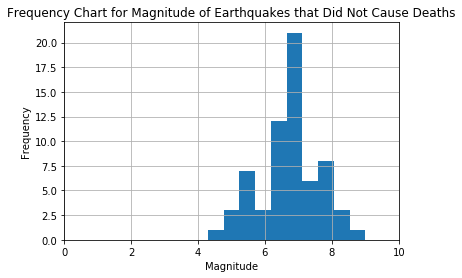

In [76]:
df_no_deaths.magnitude.hist();
plt.title('Frequency Chart for Magnitude of Earthquakes that Did Not Cause Deaths')
plt.xlabel('Magnitude')
plt.xlim(0,10)
plt.ylabel('Frequency');

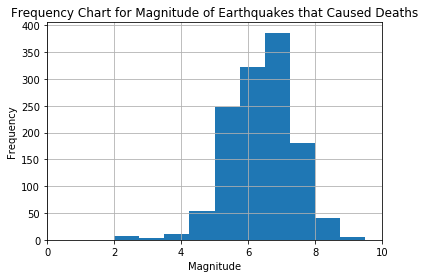

In [77]:
df_only_deaths.magnitude.hist();
plt.title('Frequency Chart for Magnitude of Earthquakes that Caused Deaths')
plt.xlabel('Magnitude')
plt.xlim(0,10)
plt.ylabel('Frequency');

In [78]:
df_no_deaths.magnitude.max()

9.0

In [79]:
df_only_deaths.magnitude.min()

2.0

## The smallest earthquake that caused deaths had a magnitude of 2.0.
## The largest earthquake that did not cause any deaths had a magnitude of 9.0.

In [80]:
df_no_deaths.loc[df['magnitude'] > 8.4]

origin              country     lat      lng depth  \
112 1923-02-03 16:01:00   Russian Federation  53.853  160.761    35   
332 1952-11-04 16:58:00  Russian Federation   52.755  160.057  22.2   

     magnitude secondary_effects  total_deaths                geometry  
112        8.5                 T           0.0  POINT (160.761 53.853)  
332        9.0                 T           0.0  POINT (160.057 52.755)

### These data points are inaccurate - at the time of these incidents, Russia was under communist rule and it's unlikely that they correctly reported the number of deaths. It's highly improbable that earthquake with a magnitude of 9.0 or of 8.5 resulted in 0 deaths. I will drop these two data points.

In [81]:
df_no_deaths = df_no_deaths.drop([332])
df_no_deaths = df_no_deaths.drop([112
                                 
                                 ])

In [82]:
df_no_deaths.magnitude.max()

8.3

In [83]:
df_no_deaths.loc[df['magnitude'] == 8.3]

origin       country    lat      lng depth  magnitude  \
123 1924-04-14 16:20:00  Philippines   7.023  125.954    33        8.3   

    secondary_effects  total_deaths               geometry  
123              None           0.0  POINT (125.954 7.023)

In [84]:
sub5_deadly = pd.DataFrame(df_only_deaths.loc[df['magnitude'] <= 5.0])

In [85]:
df_phil = df.loc[df['country'] == 'Philippines']


In [86]:
df_phil = pd.DataFrame(df_phil.loc[df_phil['magnitude'] >= 7.0])

In [87]:
df_phil = df_phil.sort_values('total_deaths')

In [88]:
df_phil['marker_color'] = pd.cut(df_phil['total_deaths'], bins=2, labels=['blue','red'])

In [89]:
df_phil.describe()

lat         lng  magnitude  total_deaths
count  19.000000   19.000000  19.000000     19.000000
mean   11.099632  123.101474   7.384211     78.421053
std     4.136447    1.977706   0.327046    165.115891
min     5.321000  119.776000   7.100000      0.000000
25%     7.322500  121.829500   7.150000      2.000000
50%    11.390000  122.878000   7.300000     15.000000
75%    14.159000  123.890500   7.500000     76.500000
max    18.000000  127.257000   8.200000    600.000000

In [90]:
df.describe()

lat          lng    magnitude   total_deaths
count  1325.000000  1325.000000  1324.000000    1325.000000
mean     21.411408    39.198997     6.396224    2375.978868
std      21.462911    80.105326     0.970012   23524.183218
min     -54.000000  -178.162000     2.000000       0.000000
25%       8.267000    -0.570000     5.700000       2.000000
50%      29.009000    51.565000     6.400000       8.000000
75%      38.000000   103.672000     7.100000      75.000000
max      66.226000   178.291000     9.500000  655237.000000

## Weird comparison:
- Average Significant Earthquake in World has a magnitude of 6.4 and death count of 2375.
- Average Significant Earthquake in the Phillipenes has a magnitude of 7.4 and death count of 78.

# Below is a map off all significant earthquakes in the Phillipenes. The red marks show earthquakes that a death toll greater than 100.

In [91]:
phill = folium.Map(location = [12, 125], zoom_start = 6)

for row in df_phil.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
    popup = (str(row_values['country'] + '<br> Date: ' + str(row_values['origin']) + '<br> Magnitude: ' + str(row_values['magnitude'])+ '<br>Total Deaths: ' + str(row_values['total_deaths'])))
    marker = folium.Marker(location=location, popup=popup, icon=folium.Icon(color=row_values['marker_color']))
    
    marker.add_to(phill)
    
phill

In [92]:
df_phil['marker_color'] = pd.cut(df_phil['total_deaths'], bins=2, labels=['blue','red'])